In [1]:
# get data
import numpy as np
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
# Open trajectories

from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)

C:\Users\Christian\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length set([500.0]) ns


In [4]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(1000L, 264L, 3L)
(1000L, 84L)


In [5]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000L, 84L)
(1000L, 4L)


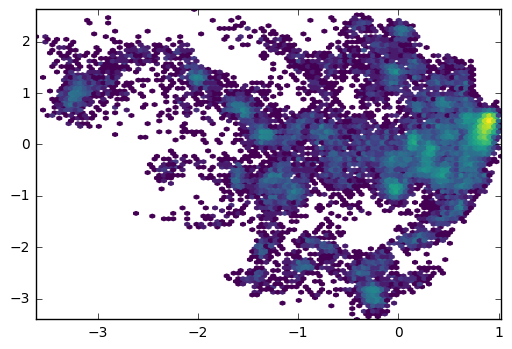

In [6]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [7]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans

num_cluster = 97
clusterer = MiniBatchKMeans(n_clusters=num_cluster, max_no_improvement=1000)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000L, 4L)
(1000L,)


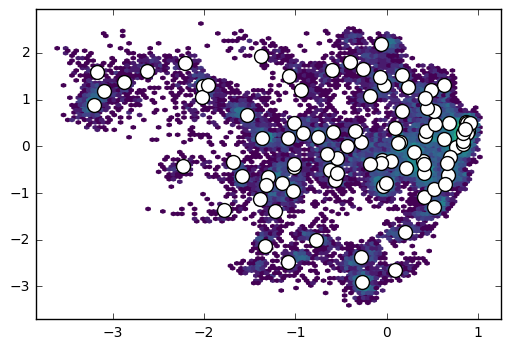

In [8]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [9]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20, ergodic_cutoff='on')
msm.fit(clustered_trajs)

MSM contains 2 strongly connected components above weight=0.50. Component 0 selected, with population 98.955053%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

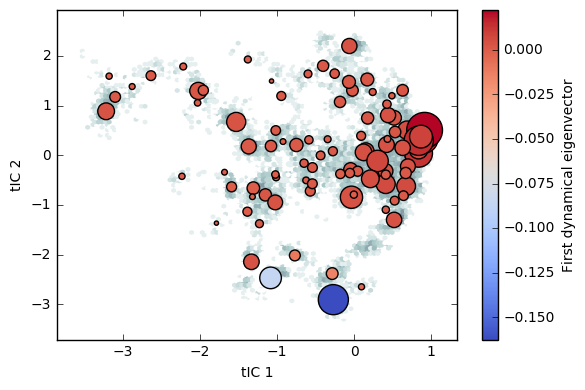

In [10]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [144]:
#Find frame limist

cluster_label = np.array([])
for array in clustered_trajs:
    if cluster_label.shape[0] == 0:
        cluster_label = array
    else:
        cluster_label = np.concatenate((cluster_label, array))

limit_list = []
state_list = []
for state in msm.mapping_.keys(): #goes through the original frame labels
    num_frame = np.where(cluster_label == state)[0].shape[0]
    prob = msm.populations_[msm.mapping_[state]]
    limit = num_frame/prob
    limit_list.append(limit)
    state_list.append(state)

limiting_state = state_list[np.argmin(limit_list)] #original frame label
max_frame = limit_list[msm.mapping_[limiting_state]]
print limiting_state, max_frame
print max_frame*msm.populations_[msm.mapping_[limiting_state]], len(np.where(cluster_label == limiting_state)[0])

22 11915.6764567
289.0 289


In [136]:
# Sample based on population vector
num_frame = max_frame+42

if num_frame > max_frame:
    print "error: exceeding max number of frames ", max_frame

num_state_frames = np.array(num_frame*msm.populations_).astype(int)

frame_idx = np.empty((0,))
for state in msm.mapping_.keys():
    options = np.where(cluster_label == state)[0]
    print state, len(options), num_state_frames[msm.mapping_[state]]
    frame_idx = np.hstack((frame_idx,np.random.choice(options, num_state_frames[msm.mapping_[state]], replace=False)))
frame_idx = frame_idx.astype(int)

X_hat = X[frame_idx, :]
X_hat.dump('raw_XYZ_'+str(num_frame)+'.dat')
frame_idx.dump('indices_'+str(num_frame)+'.dat')

 error: exceeding max number of frames  11915
0 60 27
1 365 159
2 160 56
3 790 306
5 328 108
6 197 71
7 317 137
8 359 142
9 157 83
10 694 561
11 302 97
12 328 181
13 205 93
14 1086 479
15 569 140
16 91 32
17 379 85
18 451 207
19 36 11
20 595 225
21 172 82
22 289 290


ValueError: Cannot take a larger sample than population when 'replace=False'